In [1]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.categorical import Categorical
import pandas as pd
import plotly.express as px

In [2]:
class ShapleySamplerOriginal:
    """
    For sampling player subsets from the Shapley distribution.

    Args:
      num_players: number of players.
    """

    def __init__(self, num_players):
        arange = torch.arange(1, num_players)
        w = 1 / (arange * (num_players - arange))
        w = w / torch.sum(w)
        self.categorical = Categorical(probs=w)
        self.num_players = num_players
        self.tril = torch.tril(
            torch.ones(num_players - 1, num_players, dtype=torch.float32), diagonal=0
        )

    def sample(self, batch_size, paired_sampling):
        """
        Generate sample.

        Args:
          batch_size: number of samples.
          paired_sampling: whether to use paired sampling.
        """
        num_included = 1 + self.categorical.sample([batch_size])
        S = self.tril[num_included - 1]
        # TODO ideally avoid for loops
        for i in range(batch_size):
            if paired_sampling and i % 2 == 1:
                S[i] = 1 - S[i - 1]
            else:
                S[i] = S[i, torch.randperm(self.num_players)]
        return S


class ShapleySamplerArgSortCPU:
    """
    For sampling player subsets from the Shapley distribution.

    Args:
      num_players: number of players.
    """

    def __init__(self, num_players):
        arange = torch.arange(1, num_players)
        w = 1 / (arange * (num_players - arange))
        w = w / torch.sum(w)
        self.categorical = Categorical(probs=w)
        self.num_players = num_players
        self.tril = torch.tril(
            torch.ones(num_players - 1, num_players, dtype=torch.float32), diagonal=0
        )

    def sample(self, batch_size, paired_sampling):
        """
        Generate sample.

        Args:
          batch_size: number of samples.
          paired_sampling: whether to use paired sampling.
        """
        num_included = 1 + self.categorical.sample([batch_size])
        S = self.tril[num_included - 1]
        # Generate a random ordering of indices for each row
        indices = torch.argsort(torch.rand_like(S), dim=-1)
        # Execute the permutation
        S = torch.gather(S, dim=-1, index=indices)
        if paired_sampling:
            S[1::2] = 1 - S[0 : batch_size - 1 : 2]
        return S


class ShapleySamplerArgSortGPU:
    """
    For sampling player subsets from the Shapley distribution.

    Args:
      num_players: number of players.
    """

    def __init__(self, num_players):
        arange = torch.arange(1, num_players)
        w = 1 / (arange * (num_players - arange))
        w = w / torch.sum(w)
        self.categorical = Categorical(probs=w)
        self.num_players = num_players
        self.tril = torch.tril(
            torch.ones(num_players - 1, num_players, dtype=torch.float32), diagonal=0
        ).to("cuda")

    def sample(self, batch_size, paired_sampling):
        """
        Generate sample.

        Args:
          batch_size: number of samples.
          paired_sampling: whether to use paired sampling.
        """
        num_included = (1 + self.categorical.sample([batch_size])).to("cuda")
        S = self.tril[num_included - 1]
        # Generate a random ordering of indices for each row
        indices = torch.argsort(torch.rand_like(S), dim=-1)
        # Execute the permutation
        S = torch.gather(S, dim=-1, index=indices)
        if paired_sampling:
            S[1::2] = 1 - S[0 : batch_size - 1 : 2]
        return S


class ShapleySamplerMultinomialCPU:
    """
    For sampling player subsets from the Shapley distribution.

    Args:
      num_players: number of players.
    """

    def __init__(self, num_players):
        arange = torch.arange(1, num_players)
        w = 1 / (arange * (num_players - arange))
        w = w / torch.sum(w)
        self.categorical = Categorical(probs=w)
        self.num_players = num_players
        self.tril = torch.tril(
            torch.ones(num_players - 1, num_players, dtype=torch.float32), diagonal=0
        )

    def sample(self, batch_size, paired_sampling):
        """
        Generate sample.

        Args:
          batch_size: number of samples.
          paired_sampling: whether to use paired sampling.
        """
        num_included = 1 + self.categorical.sample([batch_size])
        S = self.tril[num_included - 1]
        # Generate a random ordering of indices for each row
        ix_weights = torch.ones(batch_size, self.num_players)
        indices = torch.multinomial(ix_weights, self.num_players, replacement=False)
        # Execute the permutation
        S = torch.gather(S, dim=-1, index=indices)
        if paired_sampling:
            S[1::2] = 1 - S[0 : batch_size - 1 : 2]
        return S


class ShapleySamplerMultinomialGPU:
    """
    For sampling player subsets from the Shapley distribution.

    Args:
      num_players: number of players.
    """

    def __init__(self, num_players):
        arange = torch.arange(1, num_players)
        w = 1 / (arange * (num_players - arange))
        w = w / torch.sum(w)
        self.categorical = Categorical(probs=w)
        self.num_players = num_players
        self.tril = torch.tril(
            torch.ones(num_players - 1, num_players, dtype=torch.float32), diagonal=0
        ).to("cuda")

    def sample(self, batch_size, paired_sampling):
        """
        Generate sample.

        Args:
          batch_size: number of samples.
          paired_sampling: whether to use paired sampling.
        """
        num_included = (1 + self.categorical.sample([batch_size])).to("cuda")
        S = self.tril[num_included - 1]
        # Generate a random ordering of indices for each row
        ix_weights = torch.ones(batch_size, self.num_players).to("cuda")
        indices = torch.multinomial(ix_weights, self.num_players, replacement=False)
        # Execute the permutation
        S = torch.gather(S, dim=-1, index=indices)
        if paired_sampling:
            S[1::2] = 1 - S[0 : batch_size - 1 : 2]
        return S


class ShapleySamplerThreshCPU:
    """
    For sampling player subsets from the Shapley distribution.

    Args:
      num_players: number of players.
    """

    def __init__(self, num_players):
        arange = torch.arange(1, num_players)
        w = 1 / (arange * (num_players - arange))
        w = w / torch.sum(w)
        self.categorical = Categorical(probs=w)
        self.num_players = num_players

    def sample(self, batch_size, paired_sampling):
        """
        Generate sample.

        Args:
          batch_size: number of samples.
          paired_sampling: whether to use paired sampling.
        """
        # 'num_included' ranges from 0...num_players-2, corresponds to selecting 1...num_players-1
        num_included = self.categorical.sample([batch_size])
        # We will be generating (batch_size x self.num_players-2) samples, 
        # and we want the expected value of the sum of each row
        # to be the 'num_included' value for that row
        thresh = (num_included / (self.num_players - 2)).reshape(-1, 1)
        # random test values
        test = torch.rand(batch_size, self.num_players - 2)
        S_partial = (thresh > test).float()
        S = torch.zeros(batch_size, self.num_players)
        S[:, 1] = 1  # First column is a zero, second column is a 1
        S[:, 2:] = S_partial  # remaining columns are 0-1
        # we will now rotate each row by a random distance using gather
        # generate a [[0,...num_players-1], [0,...,num_players-1],...] matrix
        shifter = torch.arange(self.num_players).reshape(1, -1).tile(batch_size, 1)
        # rotate the indices by a random amount
        shifter = (
            shifter + torch.randint(0, self.num_players, (batch_size, 1))
        ) % self.num_players
        S = torch.gather(S, dim=-1, index=shifter)

        if paired_sampling:
            S[1::2] = 1 - S[0 : batch_size - 1 : 2]
        return S


class ShapleySamplerThreshGPU:
    """
    For sampling player subsets from the Shapley distribution.

    Args:
      num_players: number of players.
    """

    def __init__(self, num_players):
        arange = torch.arange(1, num_players)
        w = 1 / (arange * (num_players - arange))
        w = w / torch.sum(w)
        self.categorical = Categorical(probs=w)
        self.num_players = num_players

    def sample(self, batch_size, paired_sampling):
        """
        Generate sample.  

        Args:
          batch_size: number of samples.
          paired_sampling: whether to use paired sampling.
        """
        # 'num_included' ranges from 0...num_players-2, corresponds to selecting 1...num_players-1
        num_included = (self.categorical.sample([batch_size])).to("cuda")
        # We will be generating (batch_size x self.num_players-2) samples, 
        # and we want the expected value of the sum of each row
        # to be the 'num_included' value for that row
        thresh = (num_included / (self.num_players - 2)).reshape(-1, 1)
        # random test values
        test = torch.rand(batch_size, self.num_players - 2).to("cuda")
        S_partial = (thresh > test).float()
        S = torch.zeros(batch_size, self.num_players).to("cuda")
        S[:, 1] = 1  # First column is a zero, second column is a 1
        S[:, 2:] = S_partial  # remaining columns are 0-1
        # we will now rotate each row by a random distance using gather
        # generate a [[0,...num_players-1], [0,...,num_players-1],...] matrix
        shifter = (
            torch.arange(self.num_players).to("cuda").reshape(1, -1).tile(batch_size, 1)
        )
        # rotate the indices by a random amount
        shifter = (
            shifter + torch.randint(0, self.num_players, (batch_size, 1)).to("cuda")
        ) % self.num_players
        # perform the row-level of rotation
        S = torch.gather(S, dim=-1, index=shifter)

        if paired_sampling:
            S[1::2] = 1 - S[0 : batch_size - 1 : 2]
        return S

In [3]:
samplers = [
    ShapleySamplerOriginal,
    ShapleySamplerArgSortCPU,
    ShapleySamplerMultinomialCPU,
    ShapleySamplerThreshCPU,
    ShapleySamplerArgSortGPU,
    ShapleySamplerMultinomialGPU,
    ShapleySamplerThreshGPU,
]

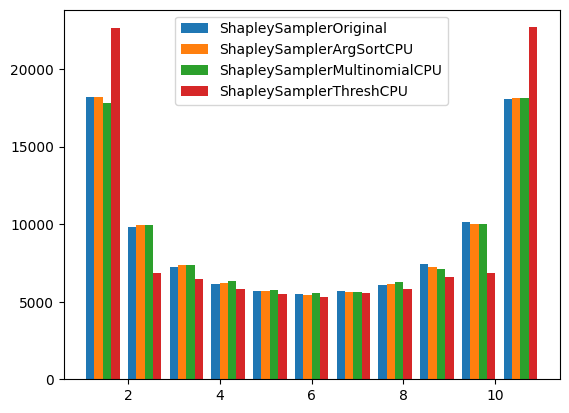

In [4]:
n = 12
samplers_distro_test = [Sampler(n) for Sampler in samplers if 'GPU' not in Sampler.__name__]
counts = [
    s.sample(100000, paired_sampling=False).sum(dim=1).cpu()
    for s in samplers_distro_test
]
plt.hist(
    counts,
    bins=n - 1,
    label=[Sampler.__class__.__name__ for Sampler in samplers_distro_test],
)
plt.legend()
plt.show()

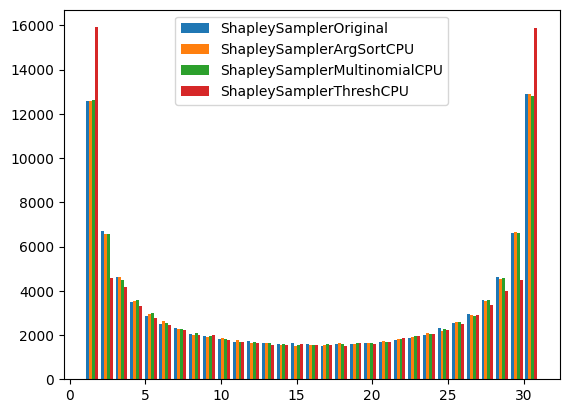

In [5]:
n = 32
samplers_distro_test = [Sampler(n) for Sampler in samplers if 'GPU' not in Sampler.__name__]
counts = [
    s.sample(100000, paired_sampling=False).sum(dim=1).cpu()
    for s in samplers_distro_test
]
plt.hist(
    counts,
    bins=n - 1,
    label=[Sampler.__class__.__name__ for Sampler in samplers_distro_test],
)
plt.legend()
plt.show()

In [6]:
def testSS(Sampler, n, num_players, batch_size):
    u = Sampler(num_players)
    s = time.time()
    for i in range(n):
        u.sample(batch_size, paired_sampling=True)
    s_per_it = (time.time() - s) / n
    return s_per_it

In [7]:
num_players = [16, 32, 64, 128, 256, 512]
batch_sizes = [16, 32, 64, 128, 256]
results = []
for i, ShapSamp in enumerate(samplers):
    for p in num_players:
        for b in batch_sizes:
            results.append(
                (i, p, b, testSS(ShapSamp, n=100, num_players=p, batch_size=b))
            )
results = pd.DataFrame(
    np.array(results), columns=["Sampler", "Number of Players", "Batch Size", "runtime"]
)

In [8]:
results["Number of Players"] = results["Number of Players"].astype(int)
results["Batch Size (log2 scale)"] = np.log2(results["Batch Size"])
results["Number of Players (log2 scale)"] = np.log2(results["Number of Players"])
results["Runtime (ms/invocation)"] = results["runtime"] * 1e3
results["Sampler Algo"] = (
    results["Sampler"]
    .astype(int)
    .map(
        {
            i: S.__name__.split("ShapleySampler")[1] for i,S in enumerate(samplers)
        }
    )
)

In [9]:
px.bar(
    results,
    x="Batch Size (log2 scale)",
    y="Runtime (ms/invocation)",
    color="Sampler Algo",
    facet_col="Number of Players",
    facet_col_wrap=3,
    barmode="group",
    height=800,
)

In [10]:
px.bar(
    results,
    x="Number of Players (log2 scale)",
    y="Runtime (ms/invocation)",
    color="Sampler Algo",
    facet_col="Batch Size",
    facet_col_wrap=3,
    barmode="group",
    height=800,
)